<a href="https://colab.research.google.com/github/Sergey-Kit/itmo_image_generation_course/blob/homework_1/tumor_unet_fpn_outer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация изображения Unet и Feature Pyramid Network.

In [ ]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Path to all data
DATA_PATH = "/kaggle_3m/"

BASE_LEN = 89
END_IMG_LEN = 4
END_MASK_LEN = 9
IMG_SIZE = 512

## Подготовка данных и аугментация

In [ ]:
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)


df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

In [ ]:
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})

def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

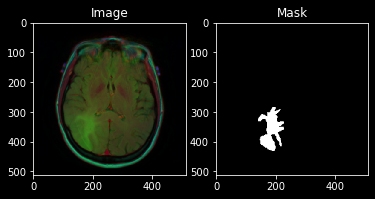

In [ ]:
sample_df = df[df["diagnosis"] == 1].sample(1).values

img = cv2.resize(cv2.imread(sample_df[0][1]), (IMG_SIZE, IMG_SIZE))
mask = cv2.resize(cv2.imread(sample_df[0][2]), (IMG_SIZE, IMG_SIZE))
sample_imgs.extend([img, mask])

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):

        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image,
                                    mask=mask)

        image = augmented['image']
        mask = augmented['mask']

        return image, mask

In [ ]:
PATCH_SIZE = 128#256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    ], p=0.8),


    A.Normalize(p=1.0),
    ToTensor(),
])


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),



    A.Normalize(p=1.0),
    ToTensor(),
])

In [ ]:
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [ ]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

## UNet

<p>
    <img src="https://miro.medium.com/max/1400/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="650" height="300">
</p>

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [ ]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)


    def forward(self, x):
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        x = self.conv_down4(x)
        x = self.upsample(x)

        x = torch.cat([x, conv3], dim=1)

        x = self.conv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.conv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.conv_up1(x)

        out = self.last_conv(x)
        out = torch.sigmoid(out)

        return out

In [ ]:
unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)

 torch.Size([1, 1, 256, 256])


## Feature Pyramid Network + UNet

In [ ]:
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, (3, 3), stride=1, padding=1, bias=False
            ),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x



class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()

        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)

In [ ]:
class FPN(nn.Module):

    def __init__(self, n_classes=1,
                 pyramid_channels=256,
                 segmentation_channels=256):
        super().__init__()

        # Bottom-up layers
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(2)

        # Top layer
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)

        # Segmentation block layers
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=n_upsamples)
            for n_upsamples in [0, 1, 2, 3]
        ])

        # Last layer
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)

    def upsample_add(self, x, y):
        _,_,H,W = y.size()
        upsample = nn.Upsample(size=(H,W), mode='bilinear', align_corners=True)

        return upsample(x) + y

    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode='bilinear', align_corners=True)
        return sample(x)

    def forward(self, x):

        # Bottom-up
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4))

        # Top-down
        p5 = self.toplayer(c5)
        p4 = self.upsample_add(p5, self.latlayer1(c4))
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2))

        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)

        # Segmentation
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]

        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4 * h, 4 * w)

        out = torch.sigmoid(out)
        return out

In [ ]:
fpn = FPN().to(device)
output = fpn(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


## Unet with ResNeXt50 backbone

In [ ]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)

        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)

        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [ ]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]

        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)

    def forward(self, x):
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)

        return out

In [ ]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth



torch.Size([1, 1, 256, 256])


# Segmentation Quality Metric

In [ ]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Segmentation Loss

In [ ]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)

def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Train Models

In [ ]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):

    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in tqdm(range(num_epochs)):
        model.train()

        losses = []
        train_iou = []

        if lr_scheduler:

            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)


        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())

            loss = train_loss(outputs, target)

            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if lr_scheduler:
                lr_scheduler.step()

        #torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)

        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)

        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(),
              "\nMean DICE on train:", np.array(train_iou).mean(),
              "\nMean DICE on validation:", val_mean_iou)

    return loss_history, train_history, val_history

In [ ]:
def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    valloss = 0

    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):

            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)

            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return valloss / i_step

In [ ]:
# Optimizers
unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)
fpn_optimizer = torch.optim.Adamax(fpn.parameters(), lr=1e-3)
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [ ]:
%%time
num_ep = 10
# Train UNet
unet_lh, unet_th, unet_vh = train_model("UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, num_ep)


  0%|          | 0/10 [00:00<?, ?it/s]

UNet



 10%|█         | 1/10 [00:26<03:57, 26.44s/it]

Epoch [0]
Mean loss on train: 1.2831103154297532 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.06666666666666667



 20%|██        | 2/10 [00:52<03:31, 26.44s/it]

Epoch [1]
Mean loss on train: 1.2847147327044914 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0



 30%|███       | 3/10 [01:19<03:05, 26.44s/it]

Epoch [2]
Mean loss on train: 1.2836380302906036 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.06666666666666667



 40%|████      | 4/10 [01:45<02:38, 26.43s/it]

Epoch [3]
Mean loss on train: 1.2832378488162468 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0



 50%|█████     | 5/10 [02:12<02:12, 26.44s/it]

Epoch [4]
Mean loss on train: 1.28286327061982 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.06666666666666667



 60%|██████    | 6/10 [02:38<01:45, 26.44s/it]

Epoch [5]
Mean loss on train: 1.2839909093133335 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0



 70%|███████   | 7/10 [03:05<01:19, 26.45s/it]

Epoch [6]
Mean loss on train: 1.2832467453233127 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0



 80%|████████  | 8/10 [03:31<00:52, 26.44s/it]

Epoch [7]
Mean loss on train: 1.283765342728845 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0



 90%|█████████ | 9/10 [03:57<00:26, 26.44s/it]

Epoch [8]
Mean loss on train: 1.2836179794936344 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0



100%|██████████| 10/10 [04:24<00:00, 26.44s/it]

Epoch [9]
Mean loss on train: 1.2856271801323726 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0
CPU times: user 4min 14s, sys: 5.38 s, total: 4min 19s
Wall time: 4min 24s


In [ ]:
# Train FPN
num_ep = 10
fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, num_ep)


  0%|          | 0/10 [00:00<?, ?it/s]

FPN



 10%|█         | 1/10 [00:20<03:07, 20.79s/it]

Epoch [0]
Mean loss on train: 0.8996554150663573 
Mean DICE on train: 0.17544601656784614 
Mean DICE on validation: 0.5227234677169678



 20%|██        | 2/10 [00:41<02:45, 20.75s/it]

Epoch [1]
Mean loss on train: 0.5972809927730724 
Mean DICE on train: 0.4928035264970084 
Mean DICE on validation: 0.49367285685307605



 30%|███       | 3/10 [01:02<02:25, 20.72s/it]

Epoch [2]
Mean loss on train: 0.501555867236236 
Mean DICE on train: 0.5673845263295297 
Mean DICE on validation: 0.661333631435946



 40%|████      | 4/10 [01:22<02:04, 20.71s/it]

Epoch [3]
Mean loss on train: 0.4581555934815571 
Mean DICE on train: 0.6057439389544859 
Mean DICE on validation: 0.618567781701873



 50%|█████     | 5/10 [01:43<01:43, 20.71s/it]

Epoch [4]
Mean loss on train: 0.43871350676335136 
Mean DICE on train: 0.6168034112972486 
Mean DICE on validation: 0.6483345178352402



 60%|██████    | 6/10 [02:04<01:22, 20.68s/it]

Epoch [5]
Mean loss on train: 0.4092339213038313 
Mean DICE on train: 0.645263276020328 
Mean DICE on validation: 0.6400832097417717



 70%|███████   | 7/10 [02:24<01:02, 20.67s/it]

Epoch [6]
Mean loss on train: 0.4086901629022483 
Mean DICE on train: 0.6429484753381467 
Mean DICE on validation: 0.6870649351456131



 80%|████████  | 8/10 [02:45<00:41, 20.66s/it]

Epoch [7]
Mean loss on train: 0.40725846832682344 
Mean DICE on train: 0.6414561591236508 
Mean DICE on validation: 0.7191509662265632



 90%|█████████ | 9/10 [03:05<00:20, 20.63s/it]

Epoch [8]
Mean loss on train: 0.3752473058371708 
Mean DICE on train: 0.6727740382449625 
Mean DICE on validation: 0.7037061216047735



100%|██████████| 10/10 [03:26<00:00, 20.67s/it]

Epoch [9]
Mean loss on train: 0.36476130218341435 
Mean DICE on train: 0.6812218097143663 
Mean DICE on validation: 0.7494544150043855


In [ ]:
# Train ResNeXt50
num_ep = 10
rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)


  0%|          | 0/10 [00:00<?, ?it/s]

ResNeXt50



 10%|█         | 1/10 [01:11<10:39, 71.07s/it]

Epoch [0]
Mean loss on train: 0.6310136460795485 
Mean DICE on train: 0.4371779164880002 
Mean DICE on validation: 0.766964206533714



 20%|██        | 2/10 [02:22<09:28, 71.07s/it]

Epoch [1]
Mean loss on train: 0.2682155792055459 
Mean DICE on train: 0.7717537961238229 
Mean DICE on validation: 0.834163902294076



 30%|███       | 3/10 [03:33<08:17, 71.04s/it]

Epoch [2]
Mean loss on train: 0.223836789293022 
Mean DICE on train: 0.8060623522657759 
Mean DICE on validation: 0.8962093193578469



 40%|████      | 4/10 [04:44<07:06, 71.02s/it]

Epoch [3]
Mean loss on train: 0.19612544678665442 
Mean DICE on train: 0.8288655759062329 
Mean DICE on validation: 0.7543153439030587



 50%|█████     | 5/10 [05:55<05:55, 71.12s/it]

Epoch [4]
Mean loss on train: 0.273857852122907 
Mean DICE on train: 0.7624726451458299 
Mean DICE on validation: 0.8988056461062931



 60%|██████    | 6/10 [07:06<04:44, 71.12s/it]

Epoch [5]
Mean loss on train: 0.20376736966186557 
Mean DICE on train: 0.8220328382922123 
Mean DICE on validation: 0.8923209760682619



 70%|███████   | 7/10 [08:17<03:33, 71.11s/it]

Epoch [6]
Mean loss on train: 0.1742384308499509 
Mean DICE on train: 0.8467685573090523 
Mean DICE on validation: 0.8890274509733793



 80%|████████  | 8/10 [09:28<02:22, 71.16s/it]

Epoch [7]
Mean loss on train: 0.1637195113018669 
Mean DICE on train: 0.8546868684663235 
Mean DICE on validation: 0.9226899728291537



 90%|█████████ | 9/10 [10:39<01:11, 71.13s/it]

Epoch [8]
Mean loss on train: 0.15788644520116263 
Mean DICE on train: 0.8603381342724175 
Mean DICE on validation: 0.9175797599451819



100%|██████████| 10/10 [11:50<00:00, 71.10s/it]

Epoch [9]
Mean loss on train: 0.16348488070070744 
Mean DICE on train: 0.8564389820822281 
Mean DICE on validation: 0.8986915061899837


## График обучения

In [ ]:
def plot_model_history(model_name,
                        train_history, val_history,
                        num_epochs):

    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()
    #plt.savefig(fn, bbox_inches='tight', pad_inches=0.2)
    #plt.close()


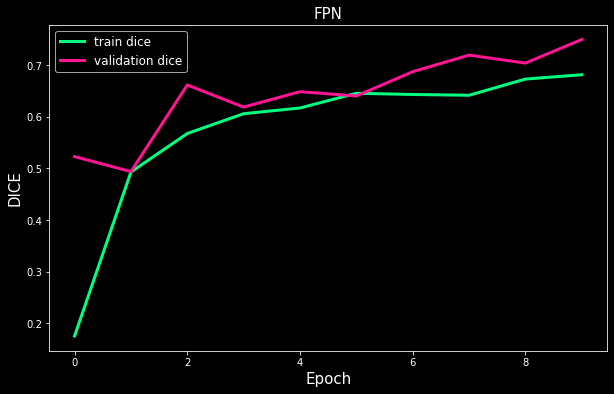

In [ ]:
plot_model_history("FPN", fpn_th, fpn_vh, 10)

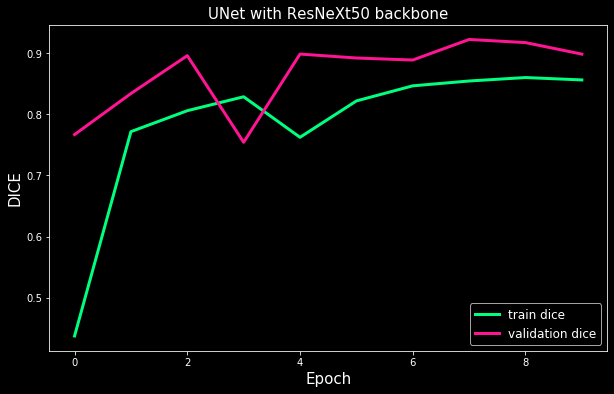

In [ ]:
plot_model_history("UNet with ResNeXt50 backbone", rx50_th, rx50_vh, num_ep)

## Test IoU

In [ ]:
test_iou = compute_iou(fpn, test_dataloader)
print(f"""FPN\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

test_iou = compute_iou(rx50, test_dataloader)
print(f"""ResNext50\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

FPN
Mean IoU of the test images - 70.0%
ResNext50
Mean IoU of the test images - 87.0%


### Пример

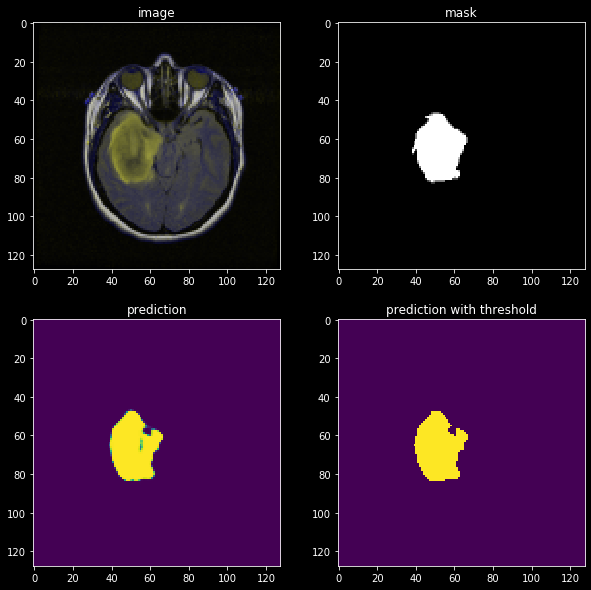

In [ ]:
# image
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()